# Homework 3: CNN

<div class="alert alert-block alert-warning">Each assignment needs to be completed independently. Never ever copy others' work (even with minor modification, e.g. changing variable names). Anti-Plagiarism software will be used to check all submissions. </div>

## Objectives:


- Use CNN for image recognition
- Use CNN for text classification

## Instructions


- Check `Lab 3: Embedding` and `Lab 4: CNN` before you start working on this assignment. These labs should give you a good starting point.
- Please complete all questions using Jupyter Notebook.
- Please answer all analysis questions using Jupyter Notebook Markdowns or in a separate pdf file (if you don't know how to write Markdowns).
- Please run your Jupyter Notebook to get all training histories and plots, save the notebook to pdf file, and sumbit the pdf file along with the Jupyter Notebook


## The FashionMNIST dataset

-  `FashionMNIST`, a dataset of article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. For details, check https://github.com/zalandoresearch/fashion-mnist
- To reduce the training time, `we'll only use 6000 images for training`
- See code below to load dataset

In [1]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torchvision.transforms as transforms

import torchvision

from numpy.random import seed
import torch
import numpy as np

from torchinfo import summary
import matplotlib.pyplot as plt

In [3]:
# Load dataset

train_dataset = torchvision.datasets.FashionMNIST('./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST('./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Randomly select 6000 for training

N = len(train_dataset)
train_dataset = Subset(train_dataset, np.random.choice(N, 6000, replace=False))

In [5]:
# Split dataset into training and evaluation

N = len(train_dataset)
train_size = int(0.7*N)
train_dataset, val_dataset = random_split(train_dataset,\
                                          lengths=[train_size, N - train_size])

print(f'Train dataset length: {len(train_dataset)}')
print(f'Validation dataset length: {len(val_dataset)}')


Train dataset length: 4200
Validation dataset length: 1800


image tensor: torch.Size([32, 1, 28, 28])
class labels: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])


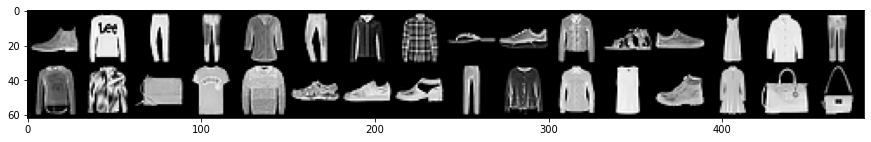

In [6]:
# Show some images from test dataset

batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
imgs, labels = next(iter(test_loader))
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=16, ncols=2, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {labels}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

## Q1: Create a CNN model to classify images 

1. In HW 2, you created a linear model to classify images. In this assignment, you'll create a CNN model to classify the same dataset and compare model performance. Carefully design your model with the following layers:
    - Convolution layers with appropriate filter design (i.e., filter size and number)
    - Maxpooling layers
    - Linear layers
    - Regularizers such as dropout
<br><br>
2. Reuse the `fit_model` function in HW 2 to fit the model and plot learning curves to show evaluation loss / accuracy vs. epoches. Tune your model carefully. Your target is to achieve `a test accuracy about 87%`.
<br><br>
3.  Compare the model performance with what you achieved in HW 2 and answer the following:
    - Compare with the best performing model in HW 2, your CNN model has more or less parameters?
    - Can you briefly explain what leads to the performance improvement in the CNN model? 

In [7]:
# Fix random number so that your traing process can be replicated

random_seed = 124
seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        # conv net
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),  # (48, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #(32, 14, 14)  if stride is not provided, it will default to kernel_size
            nn.Conv2d(in_channels=64, out_channels=24, kernel_size=2),  # (24, 12, 12)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 6, 6)        
            nn.Flatten() ,           
            nn.Dropout(0.5),
            nn.Linear(in_features = 24*6*6, out_features = 100),
            nn.Dropout(0.2),
            nn.Linear(in_features = 100, out_features = 10)
        )
       
    def forward(self, x):
        output = self.convnet(x)
    
        return output

In [9]:
class linear_model(nn.Module):
    
    # hidden_units is a list which specify the output of each layer
    def __init__(self, input_dim = 784, hidden_units=[256]):
        
        # initialize parent class
        super(linear_model, self).__init__()
        
        hidden_units = [input_dim] + hidden_units
        
        self.layers = nn.ModuleList([nn.Linear(hidden_units[i], hidden_units[i+1]) \
                                     for i in range(len(hidden_units)-1)])
    
    def forward(self, x):
        
        output = x
        #print(x.size())
        for i, layer in enumerate(self.layers):
            
            output = layer(output)
            #print(output.size())
            
            if i<len(self.layers)-1:   # no activation on the last layer
                output = F.relu(output)
        
        return output

In [10]:
def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                optimizer, epochs=30, batch_size=128):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / y.size(0)
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                
                # predict
                outputs = model(x)
                _, pred = torch.max(outputs, dim = -1)
                cur_val_loss = criterion(outputs, y)
                cur_val_acc = (pred == y).sum().item() / y.size(0) 
                
                # loss and acc
                val_loss += cur_val_loss
                val_acc += cur_val_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (val_loss/len(val_loader)).item()
        val_acc = val_acc/len(val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.3f} train_acc:{train_acc:.3f}, valid loss:{val_loss:.3f} valid acc:{val_acc:.3f}")
    

    model.eval()
    ys = []
    preds = []

    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)

            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)

            preds.append(pred.view(-1).cpu().numpy())
            ys.append(y)

    ys = np.concatenate(ys)
    preds = np.concatenate(preds)

    test_acc = (ys==preds).astype(int).sum()/len(ys)
    print(f"test acc:{test_acc:.3f}")

    return test_acc, history

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# dataset

modela = cnn_model()
summary(modela, (32, 1, 28, 28))

optimizer = torch.optim.RMSprop(modela.parameters(), lr = 0.0005)
acc_a, hista = train_model(modela, train_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.210 train_acc:0.558, valid loss:0.816 valid acc:0.708
Epoch:2 / 200, train loss:0.758 train_acc:0.719, valid loss:0.717 valid acc:0.724
Epoch:3 / 200, train loss:0.680 train_acc:0.747, valid loss:0.684 valid acc:0.758
Epoch:4 / 200, train loss:0.641 train_acc:0.764, valid loss:0.651 valid acc:0.758
Epoch:5 / 200, train loss:0.612 train_acc:0.773, valid loss:0.617 valid acc:0.772
Epoch:6 / 200, train loss:0.586 train_acc:0.780, valid loss:0.603 valid acc:0.774
Epoch:7 / 200, train loss:0.564 train_acc:0.788, valid loss:0.593 valid acc:0.779
Epoch:8 / 200, train loss:0.565 train_acc:0.786, valid loss:0.577 valid acc:0.787
Epoch:9 / 200, train loss:0.541 train_acc:0.802, valid loss:0.577 valid acc:0.798
Epoch:10 / 200, train loss:0.526 train_acc:0.806, valid loss:0.561 valid acc:0.791
Epoch:11 / 200, train loss:0.514 train_acc:0.806, valid loss:0.552 valid acc:0.799
Epoch:12 / 200, train loss:0.508 train_acc:0.809, valid loss:0.544 valid acc:0.80

In [13]:
def get_plot(hist_list, labels, epochs):
    
    colors = ['red',"blue","green","orange"]
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    for i, hist in enumerate(hist_list):
        ax[0].plot(range(len(hist['val_loss'])), hist['val_loss'], '-', color = colors[i], label=labels[i])
        
    ax[0].set_title('Evaluation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    for i, hist in enumerate(hist_list):
        ax[1].plot(range(len(hist['val_acc'])), hist['val_acc'], '-', color = colors[i], label=labels[i])
        

    ax[1].set_title('Evaluation Acc.')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc.')
    ax[1].legend()
   
    plt.show()

Test acc: model A 0.874


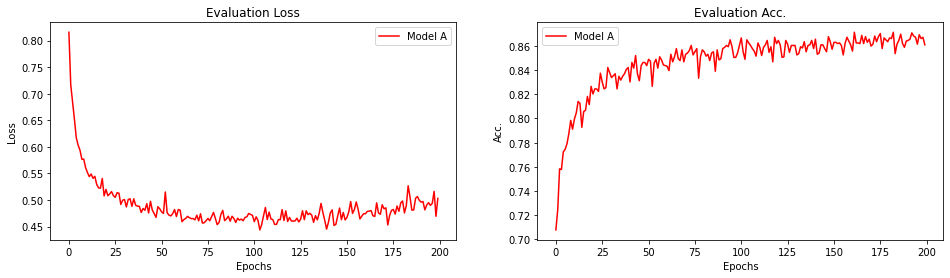

In [14]:
print(f"Test acc: model A {acc_a:.3f}")

get_plot([hista], ["Model A"], len(hista['val_loss']))

## Q2 (bonus): Further improve model performance

Can you find a way to `improve model test accuracy to above 88%`? For example, you can think about data augmentation or use pretrained image classification models.
<br><br>
Implement the techiques you take, plot the model evaluation loss / accuracy vs. epoches, and compare it with the plot in Q1. Can you explain why the techniques you choose can improve model performance?

In [15]:
# dataset with augmentation

class Fashion_Dataset(Dataset):
    def __init__(self, dataset, transformer = None):
        
        self.dataset = dataset
        
        self.transformer = transformer
    
    def __getitem__(self, index):
        # load image
        
        img, label = self.dataset[index]
        if self.transformer:
            img = self.transformer(img)
       
        return img, label
    
    def __len__(self):
        return len(self.dataset)  
    
    
def show_img(img):
    plt.figure(figsize=(5,4))  
    plt.imshow(np.transpose(img, axes=(1,2,0)), cmap="gray")

In [16]:
# data augmentation

transform = transforms.Compose([
            transforms.GaussianBlur(1),
            transforms.RandomResizedCrop((28,28), scale=(0.9, 1.1))
            ])


In [17]:
fashion_dataset = Fashion_Dataset(train_dataset, transformer = transform)
len(fashion_dataset)

4200

In [20]:
# Test transformation
imgs, labels = train_dataset[0]
#show_img(imgs)
# #x = imgs.view(1, *imgs.size())
# #x.size()

imgs, label = fashion_dataset[0]
#show_img(imgs)

In [21]:
modelb = cnn_model()
summary(modelb, (32, 1, 28, 28))


optimizer = torch.optim.RMSprop(modelb.parameters(), lr = 0.0008)
acc_b, histb = train_model(modelb, fashion_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.213 train_acc:0.562, valid loss:0.788 valid acc:0.709
Epoch:2 / 200, train loss:0.743 train_acc:0.722, valid loss:0.671 valid acc:0.752
Epoch:3 / 200, train loss:0.679 train_acc:0.745, valid loss:0.647 valid acc:0.739
Epoch:4 / 200, train loss:0.647 train_acc:0.760, valid loss:0.619 valid acc:0.766
Epoch:5 / 200, train loss:0.611 train_acc:0.771, valid loss:0.611 valid acc:0.769
Epoch:6 / 200, train loss:0.602 train_acc:0.768, valid loss:0.585 valid acc:0.791
Epoch:7 / 200, train loss:0.581 train_acc:0.781, valid loss:0.593 valid acc:0.793
Epoch:8 / 200, train loss:0.575 train_acc:0.779, valid loss:0.557 valid acc:0.799
Epoch:9 / 200, train loss:0.554 train_acc:0.786, valid loss:0.578 valid acc:0.790
Epoch:10 / 200, train loss:0.557 train_acc:0.791, valid loss:0.562 valid acc:0.797
Epoch:11 / 200, train loss:0.537 train_acc:0.799, valid loss:0.543 valid acc:0.809
Epoch:12 / 200, train loss:0.528 train_acc:0.802, valid loss:0.546 valid acc:0.80

In [22]:
modelb = cnn_model()
summary(modelb, (32, 1, 28, 28))


optimizer = torch.optim.Adam(modelb.parameters(), lr = 0.0008)
acc_b, histb = train_model(modelb, fashion_dataset, val_dataset, test_dataset, device, optimizer, epochs=200)

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 64, 26, 26]          640
│    └─ReLU: 2-2                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 64, 13, 13]          --
│    └─Conv2d: 2-4                       [32, 24, 12, 12]          6,168
│    └─ReLU: 2-5                         [32, 24, 12, 12]          --
│    └─MaxPool2d: 2-6                    [32, 24, 6, 6]            --
│    └─Flatten: 2-7                      [32, 864]                 --
│    └─Dropout: 2-8                      [32, 864]                 --
│    └─Linear: 2-9                       [32, 100]                 86,500
│    └─Dropout: 2-10                     [32, 100]                 --
│    └─Linear: 2-11                      [32, 10]                  1,010
Tota

Training Start
Epoch:1 / 200, train loss:1.687 train_acc:0.436, valid loss:0.971 valid acc:0.660
Epoch:2 / 200, train loss:0.914 train_acc:0.664, valid loss:0.789 valid acc:0.718
Epoch:3 / 200, train loss:0.760 train_acc:0.719, valid loss:0.694 valid acc:0.748
Epoch:4 / 200, train loss:0.682 train_acc:0.753, valid loss:0.675 valid acc:0.751
Epoch:5 / 200, train loss:0.649 train_acc:0.754, valid loss:0.642 valid acc:0.754
Epoch:6 / 200, train loss:0.613 train_acc:0.773, valid loss:0.606 valid acc:0.784
Epoch:7 / 200, train loss:0.596 train_acc:0.773, valid loss:0.602 valid acc:0.773
Epoch:8 / 200, train loss:0.566 train_acc:0.792, valid loss:0.600 valid acc:0.793
Epoch:9 / 200, train loss:0.563 train_acc:0.789, valid loss:0.606 valid acc:0.795
Epoch:10 / 200, train loss:0.555 train_acc:0.792, valid loss:0.565 valid acc:0.805
Epoch:11 / 200, train loss:0.541 train_acc:0.800, valid loss:0.579 valid acc:0.796
Epoch:12 / 200, train loss:0.531 train_acc:0.798, valid loss:0.541 valid acc:0.81

Test acc: model A 0.874, model B 0.887


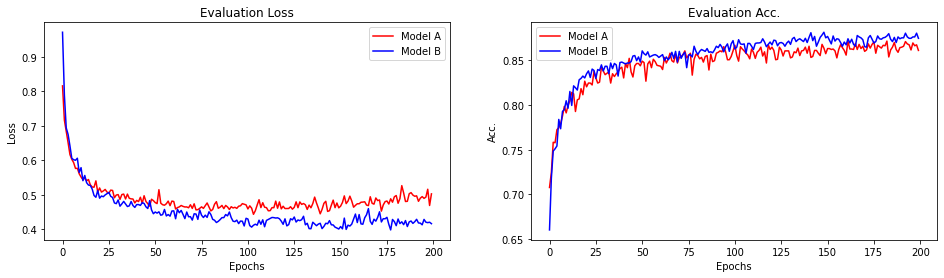

In [23]:
print(f"Test acc: model A {acc_a:.3f}, model B {acc_b:.3f}")

get_plot([hista, histb], ["Model A","Model B"], len(hista['val_loss']))

## Q3: CNN for Text Classification

In this task, we'll use CNN to detect emotion from text. The dataset is taken from https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text.


The following scripts show you how to load the data and split the samples into training, evaluation, and test.

### Load Data

In [24]:
import pandas as pd
from sklearn.utils import shuffle


In [27]:
data = pd.read_csv("sample_data/Emotion_final.csv")
data.head()
len(data)

data = shuffle(data)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


21459

In [28]:
# Map text label to numbers

label_map = {'fear':0, 'happy':1, 'anger':2, 'surprise':3, 'sadness':4, 'love':5}
data["label"] = data.Emotion.apply(lambda x: label_map[x])
data.head()
data.label.value_counts()

,Text,Emotion,label
11319,i feel impatient with the christian church dis...,anger,2
793,i feel like him try to stay as faithful as pos...,happy,1
11516,im feeling pretty proud most of the elements i...,happy,1
18681,i went to bed feeling pretty proud of myself e...,happy,1
2273,i feel heartbroken mostly for my daughter and ...,sadness,4


1    7029
4    6265
2    2993
0    2652
5    1641
3     879
Name: label, dtype: int64

In [29]:
# Split dataset into training, evaluation, and test

train_data = data.iloc[0: 15000]
eval_data = data.iloc[15000: 18000]
test_data = data.iloc[18000: ]

### Q3.1. Preprocess Text

Write a function `preprocess(train_data, eval_data, test_data)` to convert the three sample subsets into three datasets so that you can use it for model fitting. 
- This function has the three sample subsets as inputs
- During preprocessing, do the following:
    1. Tokenize each document into words
    1. Map every unique word in the vocabulary into an index (i.e. `word index`)
    1. Convert each document into a sequence of word indexes with uniform length by padding short ones and truncating long ones.
    1. Create Torch datasets for the subsets that can be directly used for training
- Return the datasets and also the word-index dictionary 


When you preprocess the text, `carefully explain how you choose the following hyperparameters`:
- Vocabulary size (i.e. the total number of words)
- Maximum sentence length


Feel free to use Keras pacakage to process text (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

[]

15959

0    14985
1      486
2      165
3       70
4       48
6       27
7       20
5       18
9       12
8        9
dtype: int64

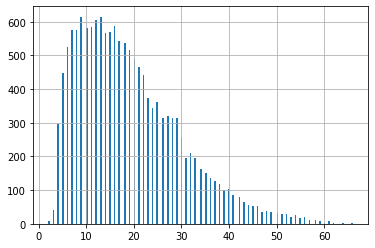

In [30]:
# A few exploration steps
from tensorflow import keras

# check document length
(train_data.apply(lambda row: len(row["Text"].split()), axis = 1)).hist(bins = 200).plot()
#(train_data.apply(lambda row: len(row["title"].split()), axis = 1)).hist(bins = 200).plot()

# check word frequencies
tokenizer = keras.preprocessing.text.Tokenizer()
#tokenizer.fit_on_texts(train_data["title"] +" "+ train_data["text"])
tokenizer.fit_on_texts(train_data["Text"])

len(tokenizer.word_counts)
word_counts = pd.Series(list(tokenizer.word_counts.values()))
(word_counts//30).value_counts().sort_values(ascending = False)[0:10]

In [31]:
class News_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).long()
        self.y = torch.Tensor(y).long()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.size()[0]


In [32]:
def preprocess(train_data, eval_data, test_data, vocab_size = 10000, max_sent = 50):
    
    tokenizer = keras.preprocessing.text.Tokenizer(num_words = vocab_size)
    tokenizer.fit_on_texts(train_data["Text"])

    train_seq = tokenizer.texts_to_sequences(train_data["Text"])
    train_seq = keras.preprocessing.sequence.pad_sequences(train_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    eval_seq = tokenizer.texts_to_sequences(eval_data["Text"])
    eval_seq = keras.preprocessing.sequence.pad_sequences(eval_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    
    test_seq = tokenizer.texts_to_sequences(test_data["Text"])
    test_seq = keras.preprocessing.sequence.pad_sequences(test_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    # dataset
    train_dataset = News_dataset(train_seq, train_data["label"].values)
    eval_dataset = News_dataset(eval_seq, eval_data["label"].values)
    test_dataset = News_dataset(test_seq, test_data["label"].values)
    
    return train_dataset, eval_dataset, test_dataset, tokenizer

In [33]:
vocab_size = 10000
max_sent = 50

train_dataset, eval_dataset, test_dataset, tokenizer = preprocess(train_data, eval_data, test_data, \
                                                       vocab_size, max_sent )

In [ ]:
#tokenizer.word_index

### 3.2. Load pretrained word vectors

Let's use pretrained word vectors. For every unique words you obtained from Q3.1., look up for the pretrained word vectors (e.g. Glove, Google word vector etc.), and create an embedding matrix which should have the shape of `(vacab_size, emb_dim)`. 


Hint: check `Lab 3: Embedding` for this task. You need to carefully choose the `embeding dimension`.

In [ ]:
#!pip install torchtext

In [34]:
import torchtext
emb_dim = 100

vector = torchtext.vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 22104.27it/s]


In [35]:

missing_words = []  # check if any word without a vector

# initialize embedding matrix
emb_weight = np.zeros((vocab_size, emb_dim))

# loop through all words
for word, idx in tokenizer.word_index.items():

  # align with word index in sentences, since the first 3 indexes are reserved
  if idx < vocab_size :  
    try:
      emb = vector[word]
      emb_weight[idx] = emb    

    # not every word has a vector
    except:
      missing_words.append(word)
    
print(missing_words)

[]


In [36]:
emb_matrix = torch.Tensor(emb_weight)
print(emb_matrix.shape)

torch.Size([10000, 100])


### 3.3. Model

Define a CNN model for this classification task. You model should provide options to configure the following parameters:
- Embedding layer 
    - vocabulary size, embedding dimension
    - Whether to use pretrained word vectors
    - If pretrained word vectors are used, whether to freeze word vectors or allow fine-tuning of word vectors<br><br>
- Convolution layer:
    - Number of filters
    - Filter sizes


In [37]:
class cnn_text(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, emb_dim, num_classes, num_filters,  \
                 kernel_sizes, emb_weight = None, freeze = False, dropout_rate = 0.5):
      
        super(cnn_text, self).__init__()
        
        self.emb_dim = emb_dim
        
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes
       
        if emb_weight is None:      
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = 0)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_weight, freeze=freeze)
        
        self.convs = nn.ModuleList([nn.Conv1d(self.emb_dim, self.num_filters, f) for f in self.kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.embedding(x) # Batch x sent_len x emb_dim
        
        x = torch.swapaxes(x, 1, 2) # Batch x emb_dim x max_sent 

        x = [F.relu(conv(x)) for conv in self.convs]  # output of three conv, batch x num_filter x L

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)  

        x = self.dropout(x)  

        logit = self.fc(x)  

        return logit

### 3.4. Train

First, carefully choose the hyperparameters for convolution layers. You can reuse the training function to train the model. Train your model with these three configuration:
- (A): Random initialize embedding layer
- (B): Initialize the embedding layer using pretrained word vectors and freeze word vectors
- (C): Initialize the embedding layer using pretrained word vectors and allow your model to fine tune word vectors
    
    
If your models are properly configured, `your test accuracy should be at least about 85% and the best performing model accuracy can be around 90%`. 


Finally, notice that you have an imbalanced dataset. To understand which classes underperform, modify the training function to print out a classification report which display the precision, recall, and f1 for each class (see function https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).



In [38]:
from sklearn.metrics import classification_report

def train_model(model, train_dataset, eval_dataset, test_dataset, device, 
                optimizer, epochs=30, batch_size=64):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'eval_loss': [],
               'eval_acc': [],
               'test_acc': 0}
    
    patience = 5
    max_acc = -np.Inf
    cnt = 0
    
    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item()
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in eval_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                
                outputs = model(x)  # (num_batch, 45) 
                _, pred = torch.max(outputs, dim = -1)
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(eval_loader)).item()
        val_acc = test_acc/len(eval_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['eval_loss'].append(val_loss)
        history['eval_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f},\
        train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
        
        if test_acc > max_acc:
            max_acc = test_acc
            cnt = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("model saved!")
        else:
            cnt += 1
            
            if cnt == patience:
                print("early stopping!")
                break
    
    # restore best model
    model.load_state_dict(torch.load("best_model.pth"))
    
    return model, history

In [39]:
def test_model(model, test_dataset, batch_size = 64):    # get test performance
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    test_acc = 0
    ys = []
    preds = []
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)
            y = y.to(device)
            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)
            
            ys.append(y.cpu().numpy())
            preds.append(pred.cpu().numpy())
    
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    
    test_acc = (preds == ys).astype(int).mean()
    print(classification_report(ys, preds))
        
    print(f"Test acc: {test_acc:.4f}")
    
    return test_acc

### Training

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
kernel_sizes = [1, 3, 5]
num_filters = 30
num_classes = 6

In [42]:
# Case A, randomly initialize embedding layer

model_cnn_a = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = None)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_a.parameters(), lr=0.0005)

model_cnn_a, hista = train_model(model_cnn_a, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_a, test_dataset)

Training Start
Epoch:1 / 100, train loss:1.6585,        train_acc:0.3192, valid loss:1.5239 valid acc:0.4062
model saved!
Epoch:2 / 100, train loss:1.5478,        train_acc:0.3727, valid loss:1.4696 valid acc:0.4491
model saved!
Epoch:3 / 100, train loss:1.4717,        train_acc:0.4261, valid loss:1.3891 valid acc:0.4887
model saved!
Epoch:4 / 100, train loss:1.3716,        train_acc:0.4803, valid loss:1.2553 valid acc:0.5595
model saved!
Epoch:5 / 100, train loss:1.2215,        train_acc:0.5546, valid loss:1.0695 valid acc:0.6325
model saved!
Epoch:6 / 100, train loss:1.0399,        train_acc:0.6321, valid loss:0.8747 valid acc:0.7089
model saved!
Epoch:7 / 100, train loss:0.8630,        train_acc:0.7033, valid loss:0.7033 valid acc:0.7672
model saved!
Epoch:8 / 100, train loss:0.7113,        train_acc:0.7576, valid loss:0.5739 valid acc:0.8194
model saved!
Epoch:9 / 100, train loss:0.5779,        train_acc:0.8084, valid loss:0.4765 valid acc:0.8457
model saved!
Epoch:10 / 100, train 

In [43]:
# Case B: Use word vectors and freeze word vectors
model_cnn_b = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = emb_matrix, freeze = True)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_b.parameters(), lr=0.0005)

model_cnn_b, hist_b = train_model(model_cnn_b, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_b, test_dataset)



Training Start
Epoch:1 / 100, train loss:1.5177,        train_acc:0.4125, valid loss:1.2838 valid acc:0.5491
model saved!
Epoch:2 / 100, train loss:1.1731,        train_acc:0.5817, valid loss:0.9817 valid acc:0.7042
model saved!
Epoch:3 / 100, train loss:0.9737,        train_acc:0.6572, valid loss:0.8228 valid acc:0.7296
model saved!
Epoch:4 / 100, train loss:0.8587,        train_acc:0.6969, valid loss:0.7196 valid acc:0.7702
model saved!
Epoch:5 / 100, train loss:0.7840,        train_acc:0.7267, valid loss:0.6551 valid acc:0.7952
model saved!
Epoch:6 / 100, train loss:0.7225,        train_acc:0.7475, valid loss:0.6052 valid acc:0.8032
model saved!
Epoch:7 / 100, train loss:0.6822,        train_acc:0.7613, valid loss:0.5703 valid acc:0.8068
model saved!
Epoch:8 / 100, train loss:0.6570,        train_acc:0.7706, valid loss:0.5353 valid acc:0.8247
model saved!
Epoch:9 / 100, train loss:0.6158,        train_acc:0.7842, valid loss:0.5139 valid acc:0.8316
model saved!
Epoch:10 / 100, train 

In [44]:
# Case C: Use word vectors and allow fine tuning

model_cnn_c = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = emb_matrix, freeze = False)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_c.parameters(), lr=0.0005)

model_cnn_c, hist_c = train_model(model_cnn_c, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_c, test_dataset)



Training Start
Epoch:1 / 100, train loss:1.5247,        train_acc:0.4059, valid loss:1.2445 valid acc:0.5871
model saved!
Epoch:2 / 100, train loss:1.0044,        train_acc:0.6593, valid loss:0.6695 valid acc:0.8109
model saved!
Epoch:3 / 100, train loss:0.5932,        train_acc:0.8108, valid loss:0.3919 valid acc:0.8757
model saved!
Epoch:4 / 100, train loss:0.4060,        train_acc:0.8707, valid loss:0.2953 valid acc:0.8974
model saved!
Epoch:5 / 100, train loss:0.3120,        train_acc:0.8965, valid loss:0.2395 valid acc:0.9058
model saved!
Epoch:6 / 100, train loss:0.2605,        train_acc:0.9111, valid loss:0.2213 valid acc:0.9105
model saved!
Epoch:7 / 100, train loss:0.2346,        train_acc:0.9223, valid loss:0.2117 valid acc:0.9119
model saved!
Epoch:8 / 100, train loss:0.2085,        train_acc:0.9254, valid loss:0.2051 valid acc:0.9148
model saved!
Epoch:9 / 100, train loss:0.1891,        train_acc:0.9335, valid loss:0.2032 valid acc:0.9152
model saved!
Epoch:10 / 100, train 